In [61]:
import multiprocessing as mp
import parmap
import sys, os
import pandas as pd
import gzip

## List of inputs
# filelist_isec = ["/scratch/tweber/DATA/NYGC_1KGP/ISEC/chr2/HG00512_NA19443/0002.vcf", "/scratch/tweber/DATA/NYGC_1KGP/ISEC/chr2/HG00512_HG00109/0002.vcf"]
ref = pd.read_csv("/scratch/tweber/DATA/1000G_SNV_with_GT/BCFTOOLS_CLEAN/merge.vcf.gz", compression="gzip", sep="\t", names=["ID", "AC", "AF", "SAMPLE"])
# ref = pd.read_parquet("/scratch/tweber/DATA/1000G_SNV_with_GT/BCFTOOLS_CLEAN/merge.parquet")
# ref = pd.read_csv(snakemake.input.ref, compression="gzip", sep="\t", nrows=10000)
ref

,ID,AC,AF,SAMPLE
0,1:54493:C:T,11,0.001718,HG00512
1,1:185275:G:C,13,0.002030,HG00512
2,1:190866:C:T,19,0.002967,HG00512
3,1:507289:T:G,25,0.003904,HG00512
4,1:666898:G:A,3,0.000468,HG00512
...,...,...,...,...
1332981,22:50764584:T:C,16,0.002498,NA19240
1332982,22:50767587:G:A,17,0.002655,NA19240
1332983,22:50777580:T:A,26,0.004060,NA19240
1332984,22:50800147:T:G,4,0.000625,NA19240


In [ ]:
l = ["HG00268", "HG00512", "HG00514", "HG00731", "HG01352", "HG02059", "HG02818", "NA19239", "NA19240"]
ref_pool = ref.loc[ref["SAMPLE"].isin(l)]
ref_pool.to_parquet("/scratch/tweber/DATA/1000G_SNV_with_GT/BCFTOOLS_CLEAN/merge_lite.parquet")


In [62]:
ref.SAMPLE.nunique()

9

In [55]:
ref_pool.SAMPLE.unique()

array(['HG00268', 'HG00512', 'HG00514', 'HG00731', 'HG01352', 'HG02059',
       'HG02818'], dtype=object)

In [99]:
f = "/scratch/tweber/DATA/1000G_SNV_with_GT/GENOTYPING/"
f_ldir = sorted([e for e in os.listdir(f) if e.endswith(".vcf.gz")])
l_df = list()

for vcf in f_ldir:
    print(vcf)
    # vcf = snakemake.input.vcf[0]
    # vcf = "/scratch/tweber/DATA/1000G_SNV_with_GT/GENOTYPING/HG00268_401.vcf.gz"

    # Nb of rows to skip at the beginning of the VCF
    skip = len([e.decode("ISO-8859–1").split('\n') for e in gzip.open("{}".format(f + vcf, "rb")) if e.decode("ISO-8859–1").split('\n')[0].startswith("##")])
    # chrom = vcf.split("/")[-3]
    sample = vcf.replace(".vcf.gz", "")
    df = pd.read_csv(f + vcf, compression="gzip", skiprows=skip, sep="\t")
    df["#CHROM"] = df["#CHROM"].astype(str)
    df["#CHROM"] = df["#CHROM"].str.replace("chr", "")
    df["ID"] = df["#CHROM"].astype(str) + ":" + df["POS"].astype(str) + ":" + df["REF"] + ":" + df["ALT"]
    # print(df)

    df = df.loc[df["QUAL"] >= 10]

    # try:
    #     df["ID"] = df["#CHROM"].astype(str) + ":" + df["POS"].astype(str) + ":" + df["REF"] + ":" + df["ALT"]
    # except:
    #     print(vcf)
    #print(df["ID"])
    # print(df)
    merge_df = pd.merge(ref, df, on="ID", how='right')
    merge_df["SAMPLE"] = merge_df["SAMPLE"].fillna("NAN")
    # print(merge_df)
    
    merge_df_gb = merge_df.groupby("SAMPLE")["ID"].nunique().sort_values(ascending=False).reset_index()
    merge_df_gb["QUERY_SAMPLE"] = sample
    merge_df_gb["Rank"] = list(range(1,1+merge_df_gb.shape[0]))
    merge_df_gb["Total_SNP"] = df.shape[0]

    l_df.append(merge_df_gb)

HG00268_401.vcf.gz
HG00268_402.vcf.gz
HG00268_404.vcf.gz
HG00268_438.vcf.gz
HG00268_455.vcf.gz
HG00512_015.vcf.gz
HG00512_017.vcf.gz
HG00512_075.vcf.gz
HG00512_081.vcf.gz
HG00512_087.vcf.gz
HG00512_092.vcf.gz
HG00514_008.vcf.gz
HG00514_015.vcf.gz
HG00514_020.vcf.gz
HG00514_023.vcf.gz
HG00514_073.vcf.gz
HG00514_089.vcf.gz
HG00514_095.vcf.gz
HG00731_019.vcf.gz
HG00731_030.vcf.gz
HG00731_086.vcf.gz
HG01352_402.vcf.gz
HG01352_410.vcf.gz
HG01352_424.vcf.gz
HG01352_442.vcf.gz
HG02059_308.vcf.gz
HG02059_326.vcf.gz
HG02059_337.vcf.gz
HG02059_348.vcf.gz
HG02059_361.vcf.gz
HG02818_308.vcf.gz
HG02818_312.vcf.gz
HG02818_332.vcf.gz
NA19239_029.vcf.gz
NA19239_055.vcf.gz
NA19239_066.vcf.gz
NA19239_090.vcf.gz
NA19240_018.vcf.gz
NA19240_033.vcf.gz
NA19240_076.vcf.gz
NA19240_081.vcf.gz
NA19240_082.vcf.gz


In [107]:
pd.options.display.max_rows = 100
concat_df = pd.concat(l_df)
concat_df.sort_values(by=["QUERY_SAMPLE", "ID"], ascending=[True, False])
concat_df["QUERY_SAMPLE_CELL"] = concat_df["QUERY_SAMPLE"]
concat_df["QUERY_SAMPLE"] = concat_df["QUERY_SAMPLE_CELL"].apply(lambda r: r.split("_")[0])
concat_df["QUERY_CELL"] = concat_df["QUERY_SAMPLE_CELL"].apply(lambda r: r.split("_")[1])
concat_df["FRACTION"] = concat_df["ID"] / concat_df["Total_SNP"]
concat_df

,SAMPLE,ID,QUERY_SAMPLE,Rank,Total_SNP,QUERY_SAMPLE_CELL,QUERY_CELL,FRACTION
0,NAN,5,HG00268,1,5,HG00268_401,401,1.000000
0,NAN,4,HG00268,1,4,HG00268_402,402,1.000000
0,NAN,2,HG00268,1,2,HG00268_404,404,1.000000
0,NAN,4,HG00268,1,5,HG00268_438,438,0.800000
1,NA19239,1,HG00268,2,5,HG00268_438,438,0.200000
...,...,...,...,...,...,...,...,...
2,NA19239,111,NA19240,3,504,NA19240_082,082,0.220238
3,HG02818,5,NA19240,4,504,NA19240_082,082,0.009921
4,HG00731,2,NA19240,5,504,NA19240_082,082,0.003968
5,HG00512,1,NA19240,6,504,NA19240_082,082,0.001984


<AxesSubplot: xlabel='QUERY_SAMPLE', ylabel='ID'>

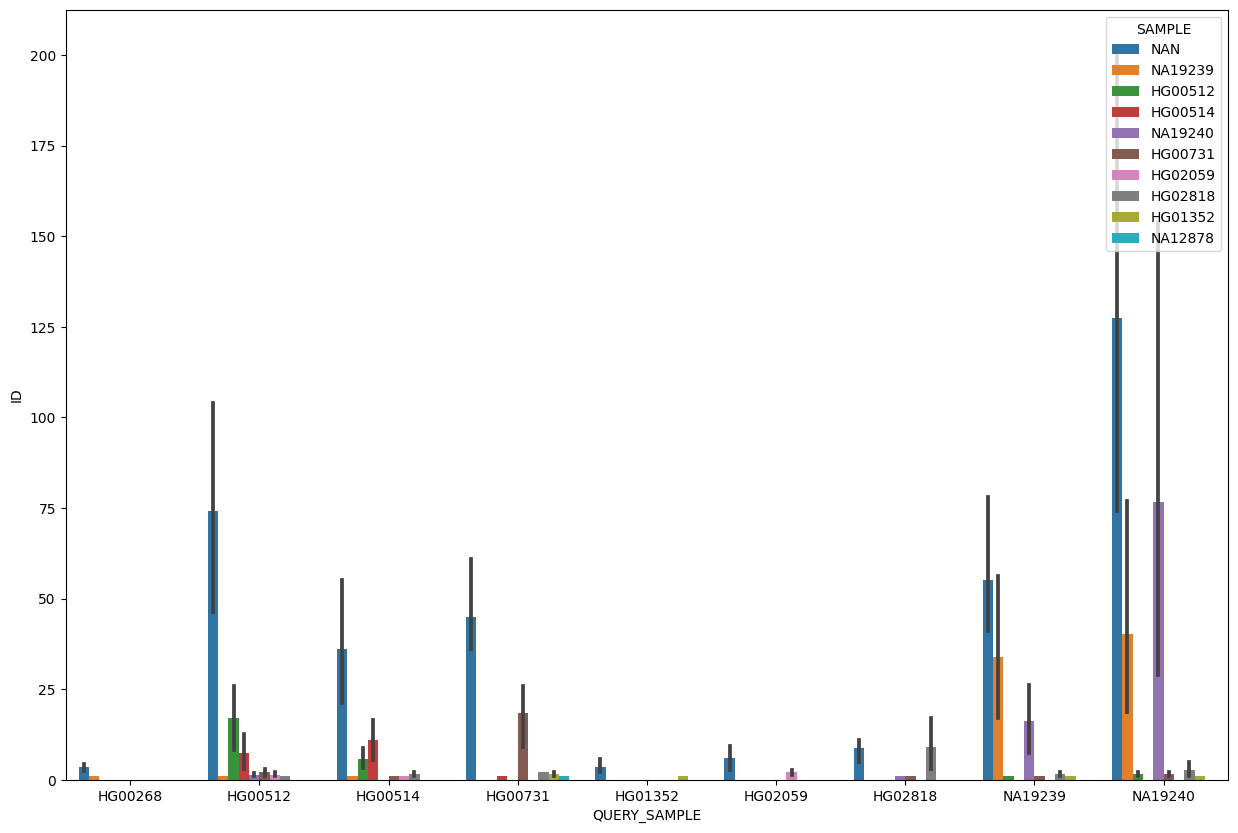

In [110]:
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm, Normalize


plt.style.use('default')
plt.figure(figsize=(15,10))
sns.barplot(data=concat_df.loc[concat_df[""]], x="QUERY_SAMPLE", y="ID", hue="SAMPLE")

<AxesSubplot: xlabel='QUERY_SAMPLE', ylabel='FRACTION'>

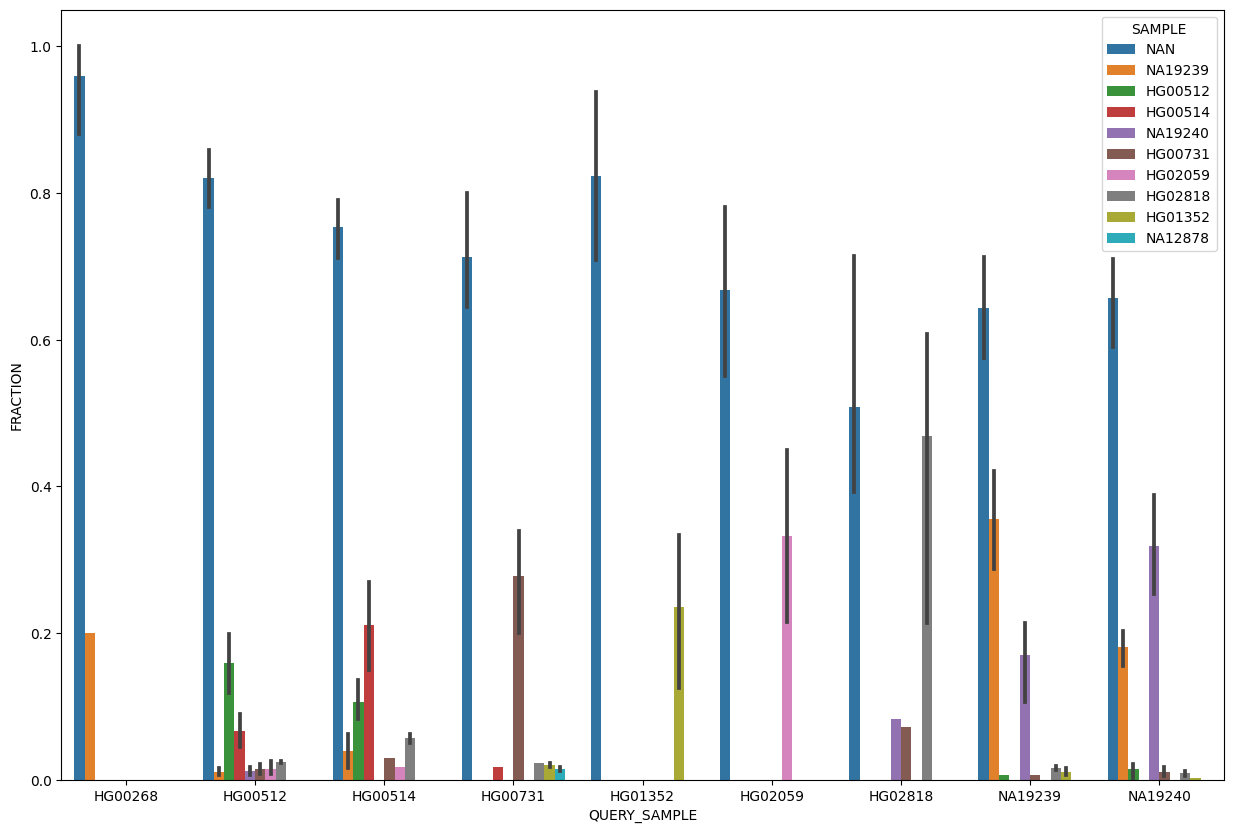

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm, Normalize


plt.style.use('default')
plt.figure(figsize=(15,10))
sns.barplot(data=concat_df, x="QUERY_SAMPLE", y="FRACTION", hue="SAMPLE")

<AxesSubplot: xlabel='QUERY_SAMPLE', ylabel='FRACTION'>

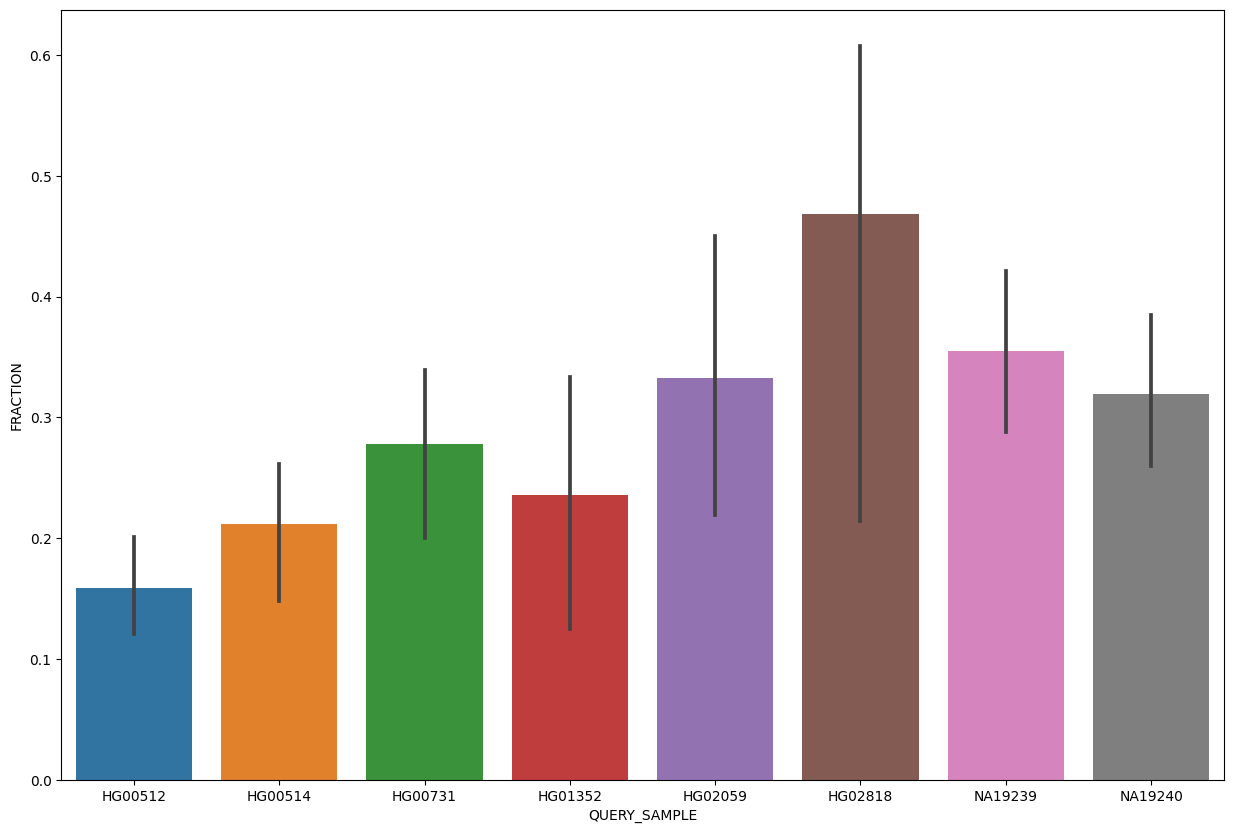

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm, Normalize


plt.style.use('default')
plt.figure(figsize=(15,10))
sns.barplot(data=concat_df.loc[concat_df["QUERY_SAMPLE"] == concat_df["SAMPLE"]], x="QUERY_SAMPLE", y="FRACTION")

<AxesSubplot: xlabel='SAMPLE', ylabel='QUERY_SAMPLE'>

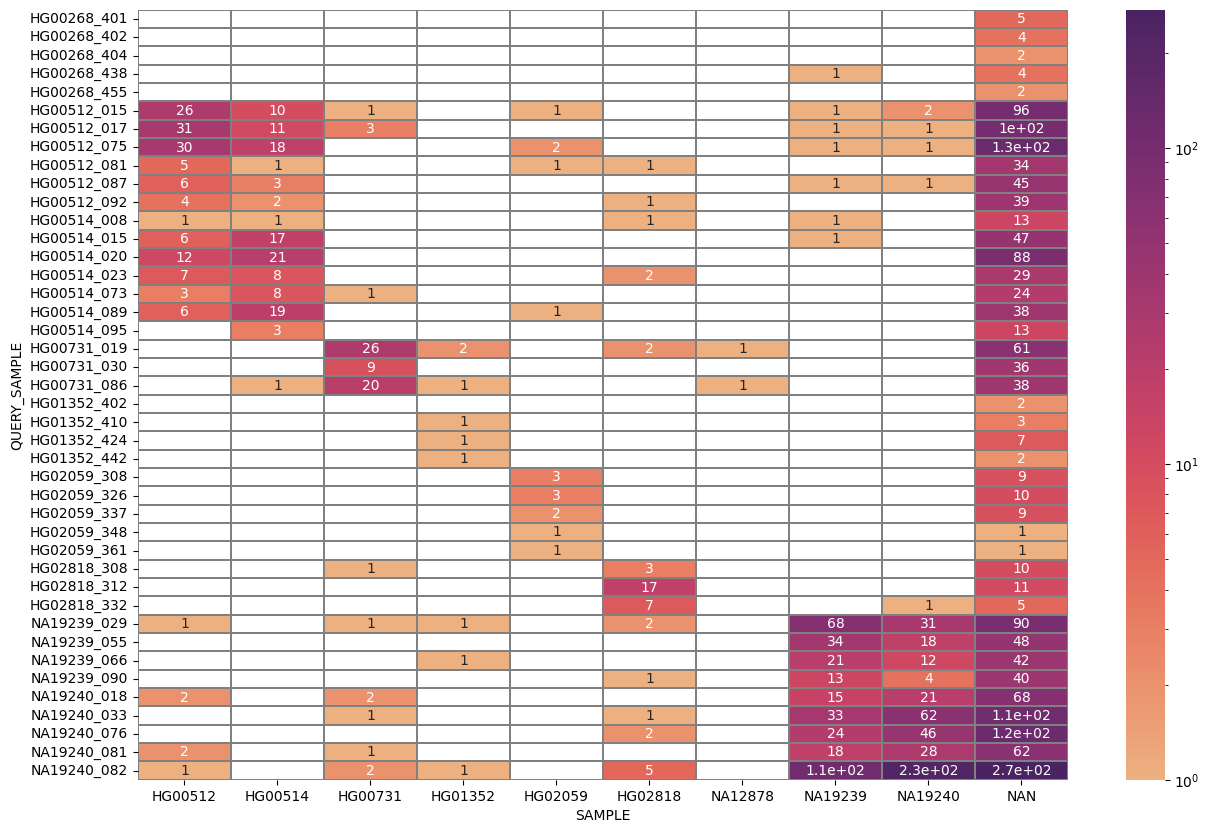

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm, Normalize


plt.style.use('default')
plt.figure(figsize=(15,10))
sns.heatmap(data=concat_df.pivot_table(index="QUERY_SAMPLE", columns="SAMPLE", values="ID"), 
linewidths=0.01, annot=True, linecolor='grey', cmap=sns.color_palette("flare", as_cmap=True), norm=LogNorm()    )